# <center> Bagging</center>

From the previous lectures, you have already learned about different classification algorithms and also learned how to properly validate and evaluate the quality of the model. But what if you have already found the best model and can no longer improve the accuracy of the model? In this case, you need to apply more advanced machine learning techniques, which can be combined with the word “ensembles”. The ensemble is a kind of collection, the parts of which form a single whole. From everyday life, you know musical ensembles, where several musical instruments are combined, architectural ensembles with different buildings, etc.

### Ensemble

A good example of ensembles is the Condorcet's jury theorem (1784). If each member of the jury has an independent opinion, and if the probability of a correct decision by a jury member is greater than 0.5, then the probability of a correct decision by the jury as a whole increases with the number of jurors and tends to one. If the probability of being right for each of the jury members is less than 0.5, then the probability of making the right decision by the jury as a whole monotonically decreases and tends to zero with an increase in the number of jurors.

- $\large N $ — number of jurors
- $\large p $ — probability of correct jury decision
- $\large \mu $ — probability of correct decision of the entire jury
- $\large m $ — minimum majority of jury members, $ m = floor(N/2) + 1 $
- $\large C_N^i$ — [combinations](https://en.wikipedia.org/wiki/Combination) $i$ elements, the number of $N$-combinations
$$ \large \mu = \sum_{i=m}^{N}C_N^ip^i(1-p)^{N-i} $$
If $\large p > 0 $, then $\large \mu > p $
If $\large N \rightarrow \infty $, then $\large \mu \rightarrow 1 $


<img src="https://github.com/terpiljenya/machine_learning_projector/blob/main/pictures/bull.png?raw=1" align="right" width=15% height=15%>


Let's look at another example of ensembles - "The Wisdom of the Crowd". Francis Galton in 1906 visited the market, where a certain lottery was held for the peasants.
There were about 800 of them and they tried to guess the weight of the bull that stood in front of them. His weight was 1198 pounds. Not a single peasant guessed the exact weight of the bull, but if we calculate the average of their predictions, we get 1197 pounds.
This idea of error reduction has also been applied to machine learning.

## Bootstrap

Bagging (or Bootstrap aggregation) is one of the first and simplest types of ensembles. It was invented by Leo Breiman in 1994. Bagging is based on the statistical method of bootstrapping, which allows estimation of many statistics of complex models.

The bootstrap method is as follows. Let there be a sample $\large X$ of size $\large N$. Let's evenly take $\large N$ objects from the sample with return. This means that we will select an arbitrary sample object $\large N$ times (we assume that each object "gets" with the same probability $\large \frac{1}{N}$), and each time we choose from all initial $\large N$ objects. One can imagine a bag from which balls are taken out: the ball chosen at some step is returned back to the bag, and the next choice is again made equiprobably from the same number of balls. Note that due to the return, there will be repetitions among them. Denote the new sample by $\large X_1$. Repeating the procedure $\large M$ times, we generate $\large M$ subsamples $\large X_1, \dots, X_M$. Now we have a sufficiently large number of samples and can evaluate various statistics of the original distribution.

Let's take a credit scoring dataset as an example. This is a binary classification task, where 0 is not overdue, 1 is overdue. One of the features in this dataset is the age of the client. Let's try to visualize the data and look at the distribution of this feature.

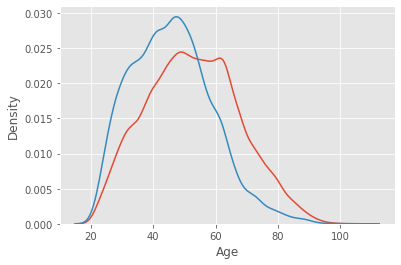

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
import seaborn as sns
%matplotlib inline

data = pd.read_csv("/content/drive/MyDrive/projector_course_data/credit_scoring_sample.csv", sep=";")

fig = sns.kdeplot(data.loc[data["SeriousDlqin2yrs"] == 0, "age"], label = "Not late payment")
fig = sns.kdeplot(data.loc[data["SeriousDlqin2yrs"] == 1, "age"], label = "Late payment")        
fig.set(xlabel="Age", ylabel="Density") 
plt.show()

As you may have noticed, the older the client of the bank, the better he repays the loan. Now it would be good to estimate the average age for each group. Since there is not enough data in our dataset, it is not entirely correct to look for the average, it is better to apply our new bootstrap knowledge. Let's generate 1000 new subsamples from our population and do an interval estimate of the mean.

In [ ]:
import numpy as np
def get_bootstrap_samples(data, n_samples):
    # function to generate subsamples using bootstrap
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    # function for interval estimation
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# saving in separate numpy arrays data on loyal and already former customers
good_credit = data.loc[data["SeriousDlqin2yrs"] == 0, "age"].values
bad_credit = data.loc[data["SeriousDlqin2yrs"] == 1, "age"].values

# set a seed for reproducible results
np.random.seed(0)

# generate samples using bootstrap and calculate the average for each group
good_credit_mean_scores = [
    np.mean(sample) for sample in get_bootstrap_samples(good_credit, 1000)
]
bad_credit_mean_scores = [
    np.mean(sample) for sample in get_bootstrap_samples(bad_credit, 1000)
]

print("Age of good creditors:  mean interval",  stat_intervals(good_credit_mean_scores, 0.05))
print("Age of bad creditors:  mean interval",  stat_intervals(bad_credit_mean_scores, 0.05))

Age of good creditors:  mean interval [52.56522391 52.87815666]
Age of bad creditors:  mean interval [45.66845452 46.17827149]


As a result, we got that with a 95% probability, the average age of loyal customers will be approximately 52-53 years old, while our bad customers are 6 years younger than them.

## Bagging

Now you have an idea about bootstrapping, we can move on to bagging. Let there be a training sample $\large X$. Using the bootstrap, we will generate $\large X_1, \dots, X_M$ samples from it. Now, on each sample, we will train our classifier $\large a_i(x)$. The final classifier will average the answers of all these algorithms (in the case of classification, this corresponds to voting): $\large a(x) = \frac{1}{M}\sum_{i = 1}^M a_i(x)$. This scheme can be represented in the picture below.

<img src="https://github.com/terpiljenya/machine_learning_projector/blob/main/pictures/bagging.png?raw=1" alt="image"/>

Consider a regression problem with basic algorithms $\large b_1(x), \dots , b_n(x)$. Assume that there is a true response function for all $\large y(x)$ objects, and a distribution on $\large p(x)$ objects is given. In this case, we can write down the error of each regression function $$ \large \varepsilon_i(x) = b_i(x) − y(x), i = 1, \dots, n$$
and write the mean squared error $$ \large E_x(b_i(x) − y(x))^{2} = E_x \varepsilon_i (x). $$

The average error of the constructed regression functions has the form $$ \large E_1 = \frac{1}{n}E_x \sum_{i=1}^n \varepsilon_i^{2}(x) $$

Assume that the errors are unbiased and uncorrelated:

$$ \large \begin{array}{rcl} E_x\varepsilon_i(x) &=& 0, \\
E_x\varepsilon_i(x)\varepsilon_j(x) &=& 0, i \neq j. \end{array}$$

Now let's build a new regression function that will average the answers of the functions we built:
$$ \large a(x) = \frac{1}{n}\sum_{i=1}^{n}b_i(x) $$

Find its root mean square error:

$$ \large \begin{array}{rcl}E_n &=& E_x\Big(\frac{1}{n}\sum_{i=1}^{n}b_i(x)-y(x)\Big)^2 \\
&=& E_x\Big(\frac{1}{n}\sum_{i=1}^{n}\varepsilon_i\Big)^2 \\
&=& \frac{1}{n^2}E_x\Big(\sum_{i=1}^{n}\varepsilon_i^2(x) + \sum_{i \neq j}\varepsilon_i(x)\varepsilon_j(x)\Big) \\
&=& \frac{1}{n}E_1\end{array}$$

Thus, averaging the answers made it possible to reduce the mean square of the error by n times!


Recall how the general error is decomposed:
$$\large \begin{array}{rcl} 
\text{Err}\left(\vec{x}\right) &=& \mathbb{E}\left[\left(y - \hat{f}\left(\vec{x}\right)\right)^2\right] \\
&=& \sigma^2 + f^2 + \text{Var}\left(\hat{f}\right) + \mathbb{E}\left[\hat{f}\right]^2 - 2f\mathbb{E}\left[\hat{f}\right] \\
&=& \left(f - \mathbb{E}\left[\hat{f}\right]\right)^2 + \text{Var}\left(\hat{f}\right) + \sigma^2 \\
&=& \text{Bias}\left(\hat{f}\right)^2 + \text{Var}\left(\hat{f}\right) + \sigma^2
\end{array}$$

Bagging allows you to reduce the variance (variance) of the trained classifier, reducing the amount by which the error will differ if the model is trained on different data sets, or in other words, it prevents overfitting. The efficiency of bagging is achieved due to the fact that the basic algorithms trained on different subsamples turn out to be quite different, and their errors are mutually compensated during voting, and also due to the fact that outlier objects may not fall into some training subsamples.

The `scikit-learn` library has an implementation of `BaggingRegressor` and `BaggingClassifier` that allows most other algorithms to be used "inside". Let's see how bagging works in practice and compare it with a decision tree using an example from [documentation](http://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py).

![image](https://github.com/terpiljenya/machine_learning_projector/blob/main/pictures/tree_vs_bagging.png?raw=1)

Decision tree error:
$$ \large 0.0255 (Err) = 0.0003 (Bias^2)  + 0.0152 (Var) + 0.0098 (\sigma^2) $$
Bagging error:
$$ \large 0.0196 (Err) = 0.0004 (Bias^2)  + 0.0092 (Var) + 0.0098 (\sigma^2) $$

From the graph and results above, it can be seen that the error of variance is much smaller with bagging, as we proved theoretically above.

Bagging is effective on small samples, when the exclusion of even a small part of training objects leads to the construction of significantly different base classifiers. In the case of large samples, subsamples of significantly smaller length are usually generated.

It should be noted that the example we have considered is not very applicable in practice, since we made the assumption of uncorrelated errors, which is rarely true. If this assumption is wrong, then the error reduction is not so significant. In the following lectures, we will consider more complex methods for combining algorithms into a composition, which allow us to achieve high quality in real problems.

### Out-of-bag error

Looking ahead, when using random forests, there is no need for cross-validation or a separate test set to get an unbiased estimate of the test set error. The internal evaluation during operation is obtained as follows:

Each tree is built using different bootstrap samples from the original data. Approximately 37% of examples remain outside the bootstrap sample and are not used when constructing the k-th tree.

This can be easily proved: let there be $\large \ell$ objects in the sample. At each step, all objects fall into the subsample with an equiprobable return, i.e. an individual object with probability $\large\frac{1}{\ell}.$ The probability that the object will NOT fall into the subsample (i.e. took $\large \ell$ times): $\large (1 - \frac{1}{\ell})^\ell$. For $\large \ell \rightarrow +\infty$ we get one of the "wonderfull" limits $\large \frac{1}{e}$. Then the probability of a particular object falling into the subsample is $\large \approx 1 - \frac{1}{e} \approx 63\%$.

Let's see how this works in practice:

![image](https://github.com/terpiljenya/machine_learning_projector/blob/main/pictures/oob.png?raw=1)

The figure shows that our classifier made a mistake in 4 observations that we did not use for training. So the accuracy of our classifier is: $\large \frac{11}{15}*100\% = 73.33\%$

It turns out that each basic algorithm is trained on ~63% of the original objects. This means that on the remaining ~37% can be checked immediately. The out-of-bag score is the average score of the underlying algorithms on those ~37% of the data on which they were not trained.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

scoring_label = data["SeriousDlqin2yrs"].astype(int)
scoring_features = data.drop(["SeriousDlqin2yrs"], axis=1)

In [ ]:
scoring_features.isnull().mean()

age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
NumberOfTimes90DaysLate                 0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
MonthlyIncome                           0.191798
NumberOfDependents                      0.024788
dtype: float64

In [ ]:
scoring_features = scoring_features.fillna(scoring_features.median())

In [ ]:
scoring_features.isnull().mean()

age                                     0.0
NumberOfTime30-59DaysPastDueNotWorse    0.0
DebtRatio                               0.0
NumberOfTimes90DaysLate                 0.0
NumberOfTime60-89DaysPastDueNotWorse    0.0
MonthlyIncome                           0.0
NumberOfDependents                      0.0
dtype: float64

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier


In [ ]:
skf = StratifiedKFold(shuffle=True, random_state=42)

In [ ]:
dt = DecisionTreeClassifier()
parameters = {"max_depth": [None, 4, 8, 12, 15], "min_samples_leaf": [1, 2, 3, 5, 8]}
r_grid_search = RandomizedSearchCV(dt, parameters, scoring ="roc_auc", cv=skf, random_state=42)
r_grid_search = r_grid_search.fit(scoring_features, scoring_label)
print(r_grid_search.best_score_)

0.8201507227439662


In [ ]:
r_grid_search.best_estimator_

DecisionTreeClassifier(max_depth=8, min_samples_leaf=5)

In [ ]:
parameters = {
    "max_features": [0.7, 0.8, 0.9], 
    "max_samples": [0.7, 0.8, 0.9], 
    "base_estimator__max_depth": [None, 4, 8, 12, 15],
    "base_estimator__min_samples_leaf": [1, 2, 3, 5, 8]
}
dt = DecisionTreeClassifier()
bg = BaggingClassifier(dt, random_state=42, n_estimators=25)
r_grid_search = RandomizedSearchCV(bg, parameters, scoring ='roc_auc', n_iter=20, cv=skf, random_state=42, n_jobs=10)
r_grid_search = r_grid_search.fit(scoring_features, scoring_label)
print(r_grid_search.best_score_)

0.8353673481426309


In [ ]:
r_grid_search.best_estimator_

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=8,
                                                        min_samples_leaf=5),
                  max_features=0.8, max_samples=0.7, n_estimators=25,
                  random_state=42)